In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco

In [11]:
df = pd.read_csv("data/close_adjusted_17.csv")

# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Set 'date' as index
df.set_index("date", inplace=True)

In [12]:
#Getting rid of missing values
df = df.ffill().bfill()

In [13]:
df.tail()

,CSCO.close,UAL.close,TROW.close,ISRG.close,PRGO.close,TPR.close,DVN.close,MRO.close,BA.close,VRTX.close,...,TSS.close,CRM.close,PGR.close,WAT.close,BWA.close,LRCX.close,NWL.close,UAA.close,BLK.close,PPL.close
date,,,,,,,,,,,,,,,,,,,,,
2023-05-19,49.13,47.54,105.4471,313.61,33.3725,42.7021,49.0047,23.07,205.49,341.70,...,118.84,210.36,135.06,267.48,45.9820,587.2413,8.6210,7.30,661.8330,26.8195
2023-05-22,48.82,47.41,105.6745,313.62,33.0850,41.8878,49.1242,23.43,205.91,339.97,...,118.84,210.26,135.63,267.81,47.4666,583.4617,8.8590,7.39,666.4888,26.7897
2023-05-23,48.91,47.87,104.8635,301.44,32.8173,41.6494,48.9151,23.64,202.60,333.51,...,118.84,206.64,133.35,265.92,46.5599,571.9135,8.9483,7.39,656.7007,26.5420
2023-05-24,48.41,46.66,102.6677,302.48,32.5793,40.6266,49.4729,24.02,199.27,333.85,...,118.84,209.06,131.50,256.99,46.0319,564.3145,8.6408,7.10,650.2184,26.2050
2023-05-25,49.03,47.48,102.9545,303.77,32.2224,40.4180,47.6800,23.33,200.87,332.63,...,118.84,209.91,128.93,259.56,46.6895,600.4449,8.3928,7.05,655.6981,25.7689


Markowitz optimization function

In [14]:
def markowitz_optimization(df):
    returns = ((df - df.shift(1)) / df.shift(1)).iloc[1:]
    def portfolio_performance(weights, mean_returns, cov_matrix):
        port_return = np.sum(mean_returns * weights)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return port_return, port_volatility

    # Optimization function
    def minimize_volatility(weights, mean_returns, cov_matrix):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    # Compute mean & covariance
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)

    # Constraints & bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]

    # Optimize for minimum volatility
    optimized_result = sco.minimize(minimize_volatility, initial_guess,
                                    args=(mean_returns, cov_matrix),
                                    method='SLSQP', bounds=bounds, constraints=constraints)

    # Return results
    optimal_weights = optimized_result.x
    return optimal_weights



Rolling Markowitz Optimization

C:\Users\vahagnd\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


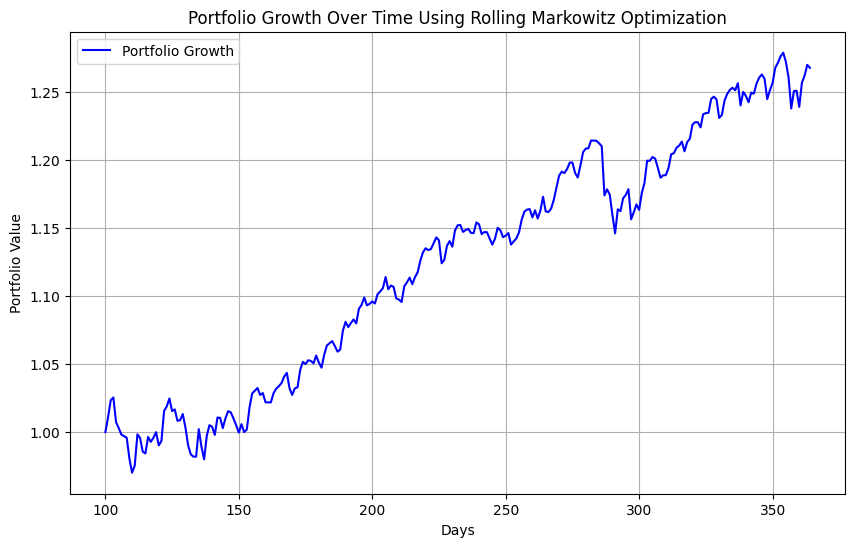

In [15]:
#Keeping smaller, 1 year data
smaller_df = df.iloc[:365]

#Returns dataframe
returns = ((smaller_df - smaller_df.shift(1)) / smaller_df.shift(1)).iloc[1:]

# Portfolio value tracking
portfolio_value = [1]  # Start with 1

# Rolling window Markowitz portfolio simulation
window_size = 100  # Use past 100 days of returns

for t in range(window_size, len(returns)):
    # Select past 100 days of returns
    returns_window = returns.iloc[t-window_size:t]

    # Compute Markowitz optimal weights
    optimal_weights = markowitz_optimization(returns_window)

    # Compute portfolio return on day 101
    next_day_return = np.dot(optimal_weights, returns.iloc[t])

    # Update portfolio value
    portfolio_value.append(portfolio_value[-1] * (1 + next_day_return))

# Convert to numpy array for easier plotting
portfolio_value = np.array(portfolio_value)

# Plot portfolio growth
plt.figure(figsize=(10, 6))
plt.plot(range(window_size, len(portfolio_value) + window_size), portfolio_value, label='Portfolio Growth', color='blue')
plt.title("Portfolio Growth Over Time Using Rolling Markowitz Optimization")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()
